In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc

import seaborn as sns


from collections import Counter

In [ ]:
from google.colab.data_table import DataTable
DataTable.max_columns = 30
DataTable.max_rows = 20000


### csv to parquet

In [ ]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [ ]:
from os.path import join
base_path = '/content/drive/MyDrive/data/dacon_jeju_2022'
parquet_flag = True
if parquet_flag:
  csv_to_parquet(join(base_path, 'train.csv'), 'train')
  csv_to_parquet(join(base_path, 'test.csv'), 'test')
  train = pd.read_parquet('/content/train.parquet')#(join(base_path, 'train.parquet'))
  test = pd.read_parquet('/content/test.parquet')#(join(base_path, 'test.parquet'))

else:
  train = pd.read_csv(join(base_path, 'train.csv'))
  test =  pd.read_csv(join(base_path, 'test.csv'))


train Done.
test Done.


In [ ]:
train[['start_turn_restricted', 'end_turn_restricted']]

,start_turn_restricted,end_turn_restricted
0,없음,없음
1,있음,없음
2,없음,없음
3,없음,없음
4,없음,없음
...,...,...
4701212,없음,없음
4701213,없음,없음
4701214,없음,없음
4701215,없음,없음


In [ ]:
train.columns

Index(['id', 'base_date', 'day_of_week', 'base_hour', 'road_in_use',
       'lane_count', 'road_rating', 'road_name', 'multi_linked',
       'connect_code', 'maximum_speed_limit', 'vehicle_restricted',
       'weight_restricted', 'height_restricted', 'road_type',
       'start_node_name', 'start_latitude', 'start_longitude',
       'start_turn_restricted', 'end_node_name', 'end_latitude',
       'end_longitude', 'end_turn_restricted', 'target',
       'lane_count + road_rating', 'lane_count / road_rating', 'dt_date',
       'year', 'month', 'day', 'yearmonth', 'distance_lat', 'distance_long',
       'distance', 'distance_std', 'mean_target', 'time_mean_target',
       'time_end_mean_target', 'start_turn_restricted + end_turn_restricted'],
      dtype='object')

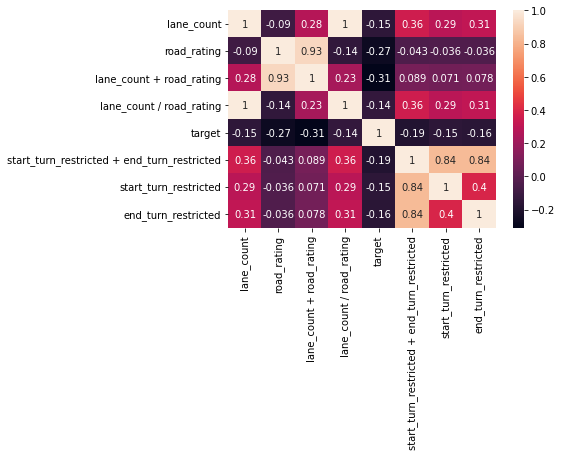

In [ ]:
sns.heatmap(train[[
       'lane_count', 'road_rating','lane_count + road_rating', 'lane_count / road_rating', 'target',
       'start_turn_restricted + end_turn_restricted', 'start_turn_restricted', 'end_turn_restricted'
      ]].corr(), annot=True)

### 시작과 끝 거리를 기준으로 정렬

In [ ]:
# train에 위도경도 거리를 넣어서 정렬
train['distance_lat'] = abs(train['start_latitude']-train['end_latitude'])
train['distance_long'] = abs(train['start_longitude']-train['end_longitude'])
train['distance'] = (train['distance_lat']**2 + train['distance_long']**2) ** 0.5

test['distance_lat'] = abs(test['start_latitude']-test['end_latitude'])
test['distance_long'] = abs(test['start_longitude']-test['end_longitude'])
test['distance'] = (test['distance_lat']**2 + test['distance_long']**2) ** 0.5

In [ ]:
train_dist = train.sort_values(by='distance').reset_index(drop=True)

In [ ]:
# 누적 분포도

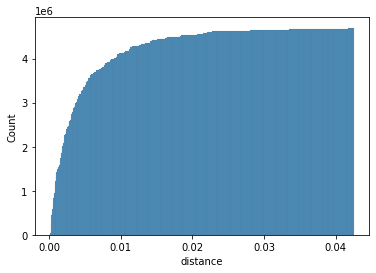

In [ ]:
import seaborn as sns
sns.histplot(data=train_dist, x='distance', cumulative=True)
plt.show()

### 지도

In [ ]:
import folium
m = folium.Map(location=[33.3, 126.5],
               zoom_start=12,
               width=750,
               height=500
               )
from folium.plugins import MarkerCluster
marker_cluster = MarkerCluster().add_to(m)

In [ ]:
idx = 0
while idx < 10000:
  folium.Marker([train_dist.loc[idx, 'start_latitude'], train_dist.loc[idx, 'start_longitude']]).add_to(marker_cluster)
  idx += 1
m

In [ ]:
m

In [ ]:
train_dist_re = train.sort_values(by='distance', ascending=False).reset_index(drop=True)

In [ ]:
import folium
m = folium.Map(location=[33.3, 126.5],
               zoom_start=12,
               width=750,
               height=500
               )
from folium.plugins import MarkerCluster
marker_cluster = MarkerCluster().add_to(m)

In [ ]:
idx = 0
while idx < 10000:
  folium.Marker([train_dist_re.loc[idx, 'end_latitude'], train_dist_re.loc[idx, 'end_longitude']]).add_to(marker_cluster)
  idx += 1
m

### EDA

In [ ]:
train.columns

Index(['id', 'base_date', 'day_of_week', 'base_hour', 'road_in_use',
       'lane_count', 'road_rating', 'road_name', 'multi_linked',
       'connect_code', 'maximum_speed_limit', 'vehicle_restricted',
       'weight_restricted', 'height_restricted', 'road_type',
       'start_node_name', 'start_latitude', 'start_longitude',
       'start_turn_restricted', 'end_node_name', 'end_latitude',
       'end_longitude', 'end_turn_restricted', 'target'],
      dtype='object')

In [ ]:
train.base_date.sort_values()

430379     20210901
369019     20210901
1132647    20210901
4543127    20210901
3428956    20210901
             ...   
2053638    20220731
2748124    20220731
2447938    20220731
3749761    20220731
4680098    20220731
Name: base_date, Length: 4701217, dtype: int64

In [ ]:
train['base_date_2'] = train['base_date'] % 20200000
train['base_date_2']

0          20623
1          20728
2          11010
3          20311
4          11005
           ...  
4701212    11104
4701213    20331
4701214    20613
4701215    11020
4701216    11019
Name: base_date_2, Length: 4701217, dtype: int64

### 트레이닝1(이전)

In [ ]:
str_col = ['day_of_week', 'start_turn_restricted', 'end_turn_restricted', ]
for i in str_col:
  le = LabelEncoder()
  le = le.fit(train[i])
  train[i] = le.transform(train[i])

  for label in np.unique(test[i]):
    if label not in le.classes_:
      le.classes_ = np.append(le.classes_, label)
  test[i] = le.transform(test[i])

In [ ]:
train.columns

Index(['id', 'base_date', 'day_of_week', 'base_hour', 'road_in_use',
       'lane_count', 'road_rating', 'road_name', 'multi_linked',
       'connect_code', 'maximum_speed_limit', 'vehicle_restricted',
       'weight_restricted', 'height_restricted', 'road_type',
       'start_node_name', 'start_latitude', 'start_longitude',
       'start_turn_restricted', 'end_node_name', 'end_latitude',
       'end_longitude', 'end_turn_restricted', 'target'],
      dtype='object')

In [ ]:
# 지울 컬럼: height_restricted, vehicle_restricted

In [ ]:
y_train = train['target']
X_train = train.drop(['height_restricted', 'road_in_use', 'id', 'base_date', 'target', 'multi_linked', 'connect_code', 'road_name', 'start_node_name', 'end_node_name','vehicle_restricted'], axis=1)
test = test.drop(['height_restricted', 'road_in_use', 'id','base_date',  'multi_linked', 'connect_code', 'road_name', 'start_node_name', 'end_node_name','vehicle_restricted'], axis=1)

print(X_train.shape)
print(y_train.shape)
print(test.shape)

In [ ]:
LR = lgb.LGBMRegressor(random_state=42).fit(X_train, y_train)

In [ ]:
pred = LR.predict(test)
sample_submission = pd.read_csv(join(base_path, 'sample_submission.csv'))
sample_submission['target'] = pred
# sample_submission.to_csv("./submit.csv", index = False)


In [ ]:
from sklearn.metrics import mean_absolute_error
pred = LR.predict(X_train)
mean_absolute_error(y_train, pred)


NameError: ignored

In [ ]:
train = pd.read_parquet('/content/train.parquet')#(join(base_path, 'train.parquet'))
test = pd.read_parquet('/content/test.parquet')#(join(base_path, 'test.parquet'))

In [ ]:
plt.figure(figsize=(20,100))
sns.boxplot(data=train, x='target', y='end_latitude', orient='h')
plt.show()

# 트레이닝 2

In [ ]:
train.columns

Index(['id', 'base_date', 'day_of_week', 'base_hour', 'road_in_use',
       'lane_count', 'road_rating', 'road_name', 'multi_linked',
       'connect_code', 'maximum_speed_limit', 'vehicle_restricted',
       'weight_restricted', 'height_restricted', 'road_type',
       'start_node_name', 'start_latitude', 'start_longitude',
       'start_turn_restricted', 'end_node_name', 'end_latitude',
       'end_longitude', 'end_turn_restricted', 'target'],
      dtype='object')

In [ ]:
train.head()

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,0,1,106,지방도1112호선,0,0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,0,2,103,일반국도11호선,0,0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,0,2,103,일반국도16호선,0,0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,0,2,107,태평로,0,0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,0,2,103,일반국도12호선,0,0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


In [ ]:
def insert_datetime(df):  
  df['base_date'] = df['base_date'].astype(str)
  df['dt_date'] = pd.to_datetime(df['base_date'])
  df['yearmonth'] = df['base_date'].str[:6].apply(int)
  df['year'] = df['dt_date'].dt.year
  df['month'] = df['dt_date'].dt.month
  df['day'] = df['dt_date'].dt.day
insert_datetime(train)
insert_datetime(test)
test.yearmonth

0         202208
1         202208
2         202208
3         202208
4         202208
           ...  
291236    202208
291237    202208
291238    202208
291239    202208
291240    202208
Name: yearmonth, Length: 291241, dtype: int64

In [ ]:
train['distance_lat'] = abs(train['start_latitude']-train['end_latitude'])
train['distance_long'] = abs(train['start_longitude']-train['end_longitude'])
train['distance'] = (train['distance_lat']**2 + train['distance_long']**2) ** 0.5

test['distance_lat'] = abs(test['start_latitude']-test['end_latitude'])
test['distance_long'] = abs(test['start_longitude']-test['end_longitude'])
test['distance'] = (test['distance_lat']**2 + test['distance_long']**2) ** 0.5

In [ ]:
train['distance_std'] = np.log1p(train['distance']*100000)
test['distance_std'] = np.log1p(test['distance']*100000)
test['distance_std']

0         5.664072
1         7.019357
2         5.218605
3         5.501245
4         7.160300
            ...   
291236    5.770649
291237    6.171280
291238    5.963654
291239    4.546775
291240    4.462464
Name: distance_std, Length: 291241, dtype: float64

#### label 인코딩 순서 바꾸기

In [ ]:
train.groupby(["weight_restricted"])[["target"]].mean()

,target
weight_restricted,
0.0,40.955696
32400.0,47.453350
43200.0,57.883888
50000.0,47.088665


In [ ]:
# label 인코딩 순서 바꾸기
def weight_restricted_encoding(x):
    if x == 0:
        y = 0
    if x == 50000:
        y = 1
    if x == 32400:
        y = 2
    if x == 43200:
        y = 3    
    return y

train["weight_restricted_en"] = train["weight_restricted"].apply(weight_restricted_encoding)
test["weight_restricted_en"] = test["weight_restricted"].apply(weight_restricted_encoding)

In [ ]:
def lane_encoding(x):
    if x == 3:
        return 0

train["lane_val_en"] = train["lane_count"].apply(lane_encoding)
test["lane_val_en"] = test["lane_count"].apply(lane_encoding)

In [ ]:
train.head()

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,...,end_turn_restricted,target,dt_date,year,month,day,yearmonth,distance_lat,distance_long,distance
0,TRAIN_0000000,20220623,목,17,0,1,106,지방도1112호선,0,0,...,없음,52.0,2022-06-23,2022,6,23,20226,0.000001,0.000277,0.000277
1,TRAIN_0000001,20220728,목,21,0,2,103,일반국도11호선,0,0,...,없음,30.0,2022-07-28,2022,7,28,20227,0.004081,0.002867,0.004987
2,TRAIN_0000002,20211010,일,7,0,2,103,일반국도16호선,0,0,...,없음,61.0,2021-10-10,2021,10,10,202110,0.000927,0.006450,0.006516
3,TRAIN_0000003,20220311,금,13,0,2,107,태평로,0,0,...,없음,20.0,2022-03-11,2022,3,11,20223,0.000515,0.000976,0.001104
4,TRAIN_0000004,20211005,화,8,0,2,103,일반국도12호선,0,0,...,없음,38.0,2021-10-05,2021,10,5,202110,0.000462,0.003601,0.003630


#### 요일 인코딩

In [ ]:
def day_encoding(x):
  day_dic = {'월':0, '화':1, '수':2, '목':3,
             '금':4, '토':5, '일':6}
  return day_dic[x]
train['day_of_week'] = train['day_of_week'].apply(day_encoding)
test['day_of_week'] = test['day_of_week'].apply(day_encoding)

In [ ]:
# train['day_hour'] = train['day_of_week']*24 + train['base_hour']
# test['day_hour'] = test['day_of_week']*24 + test['base_hour']
# train.head()

In [ ]:
# label encoding
str_col = ['start_turn_restricted', 'end_turn_restricted', # day_of_week
           'road_name', 'start_node_name', 'end_node_name'] 
for i in str_col:
  le = LabelEncoder()
  le = le.fit(train[i])
  train[i] = le.transform(train[i])

  for label in np.unique(test[i]):
    if label not in le.classes_:
      le.classes_ = np.append(le.classes_, label)
  test[i] = le.transform(test[i])

In [ ]:
train.columns

Index(['id', 'base_date', 'day_of_week', 'base_hour', 'road_in_use',
       'lane_count', 'road_rating', 'road_name', 'multi_linked',
       'connect_code', 'maximum_speed_limit', 'vehicle_restricted',
       'weight_restricted', 'height_restricted', 'road_type',
       'start_node_name', 'start_latitude', 'start_longitude',
       'start_turn_restricted', 'end_node_name', 'end_latitude',
       'end_longitude', 'end_turn_restricted', 'target', 'dt_date', 'year',
       'month', 'day', 'yearmonth', 'distance_lat', 'distance_long',
       'distance', 'day_hour'],
      dtype='object')

In [ ]:
s1.issubset(s2)

True

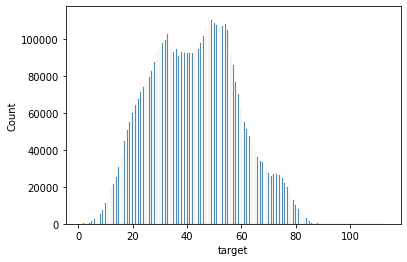

In [ ]:
sns.histplot(train['target'])
plt.show()

### 평균속력 치팅
위치별 평균 속력

In [ ]:
train_part = train.groupby('end_longitude')['target'].mean().to_frame().reset_index()
train_part.rename(columns={'target':'mean_target'}, inplace=True)

In [ ]:
train = pd.merge(train, train_part, on='end_longitude')
test = pd.merge(test, train_part, how='left', on='end_longitude')

위치+시간별 평균 속력

In [ ]:
time_end_group = train.groupby(['base_hour', 'end_longitude'])['target'].mean().to_frame().reset_index()
time_end_group.rename(columns={'target':'time_end_mean_target'}, inplace=True)

In [ ]:
train = pd.merge(train, time_end_group, on=['base_hour', 'end_longitude'])
test = pd.merge(test, time_end_group, how='left',on=['base_hour', 'end_longitude'])

In [ ]:
test[['id', 'base_hour', 'end_longitude', 'time_end_mean_target']]

,id,base_hour,end_longitude,time_end_mean_target
0,TEST_000000,17,126.543837,25.538153
1,TEST_000001,12,126.415840,34.628684
2,TEST_000002,2,126.474687,61.241237
3,TEST_000003,23,126.545467,33.411885
4,TEST_000004,17,126.581230,42.994048
...,...,...,...,...
291236,TEST_291236,5,126.460846,48.129412
291237,TEST_291237,20,126.600332,52.566337
291238,TEST_291238,11,126.496946,23.668000
291239,TEST_291239,7,126.507333,25.423581


index가 꼬였는지 확인

In [ ]:
test.columns

Index(['id', 'base_date', 'day_of_week', 'base_hour', 'road_in_use',
       'lane_count', 'road_rating', 'road_name', 'multi_linked',
       'connect_code', 'maximum_speed_limit', 'vehicle_restricted',
       'weight_restricted', 'height_restricted', 'road_type',
       'start_node_name', 'start_latitude', 'start_longitude',
       'start_turn_restricted', 'end_node_name', 'end_latitude',
       'end_longitude', 'end_turn_restricted', 'lane_count + road_rating',
       'lane_count / road_rating', 'dt_date', 'year', 'month', 'day',
       'yearmonth', 'distance_lat', 'distance_long', 'distance',
       'distance_std', 'mean_target', 'time_mean_target',
       'time_end_mean_target'],
      dtype='object')

In [ ]:
test['id']

0         TEST_000000
1         TEST_000001
2         TEST_000002
3         TEST_000003
4         TEST_000004
             ...     
291236    TEST_291236
291237    TEST_291237
291238    TEST_291238
291239    TEST_291239
291240    TEST_291240
Name: id, Length: 291241, dtype: object

### 데이터셋 늘리기 (6~7월)

In [ ]:
indices = train[train['yearmonth']>=202206]

In [ ]:
train = pd.concat([train, indices])

In [ ]:
def feature_eng(data):
    data['lane_count + road_rating'] = data['lane_count'] + data['road_rating']
    #data['lane_count / road_rating'] = data['lane_count'] / data['road_rating']
    #data.loc[np.isinf(data['lane_count / road_rating']), 'lane_count / road_rating'] = 0
    #data['lane_count / road_rating'].fillna(0, inplace=True)
feature_eng(train)
feature_eng(test)

In [ ]:
def feature_eng(data):
    data['start_turn_restricted + end_turn_restricted'] = data['start_turn_restricted'] + data['end_turn_restricted']
    #data['lane_count / road_rating'] = data['start_turn_restricted'] / data['road_rating']
    #data.loc[np.isinf(data['lane_count / road_rating']), 'lane_count / road_rating'] = 0
    #data['lane_count / road_rating'].fillna(0, inplace=True)
feature_eng(train)
feature_eng(test)

학습후 feature importance 출력


In [ ]:
train.columns

Index(['id', 'base_date', 'day_of_week', 'base_hour', 'road_in_use',
       'lane_count', 'road_rating', 'road_name', 'multi_linked',
       'connect_code', 'maximum_speed_limit', 'vehicle_restricted',
       'weight_restricted', 'height_restricted', 'road_type',
       'start_node_name', 'start_latitude', 'start_longitude',
       'start_turn_restricted', 'end_node_name', 'end_latitude',
       'end_longitude', 'end_turn_restricted', 'target',
       'lane_count + road_rating', 'lane_count / road_rating', 'dt_date',
       'year', 'month', 'day', 'yearmonth', 'distance_lat', 'distance_long',
       'distance', 'distance_std', 'mean_target', 'time_mean_target',
       'time_end_mean_target'],
      dtype='object')

In [ ]:
train.head()

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,...,day,yearmonth,distance_lat,distance_long,distance,distance_std,mean_target,time_mean_target,time_end_mean_target,start_turn_restricted + end_turn_restricted
0,TRAIN_0000000,20220623,3,17,0,1,106,46,0,0,...,23,20226,0.000001,0.000277,0.000277,3.357067,51.75691,38.473363,50.865471,0
1,TRAIN_0045467,20210913,0,17,0,1,106,46,0,0,...,13,20219,0.000001,0.000277,0.000277,3.357067,51.75691,38.473363,50.865471,0
2,TRAIN_0052833,20210904,5,17,0,1,106,46,0,0,...,4,20219,0.000001,0.000277,0.000277,3.357067,51.75691,38.473363,50.865471,0
3,TRAIN_0067349,20220220,6,17,0,1,106,46,0,0,...,20,20222,0.000001,0.000277,0.000277,3.357067,51.75691,38.473363,50.865471,0
4,TRAIN_0079551,20211212,6,17,0,1,106,46,0,0,...,12,202112,0.000001,0.000277,0.000277,3.357067,51.75691,38.473363,50.865471,0



### train, val 생성


모델: XGB, LGBM, CatBoost, HGBM
pycaret
stacking ensemble

In [ ]:
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
seed = 42
y_train = train['target']
X_train = train[[ 'yearmonth', 'day_of_week', 'base_hour',
                  'weight_restricted', 'lane_count',
                  'maximum_speed_limit', 'road_type', 'road_rating',
                  'road_name', 'start_node_name', 'end_node_name',
                  'start_latitude', 'start_longitude', 'start_turn_restricted', 'end_latitude', 'end_longitude', 'end_turn_restricted', 'distance_std',
                  ]]
#X_train['base_date'] = X_train['base_date'].astype(int) 
X_test = test[[   'yearmonth', 'day_of_week', 'base_hour',
                  'weight_restricted', 'lane_count', 
                  'maximum_speed_limit', 'road_type', 'road_rating', 
                  'road_name', 'start_node_name', 'end_node_name',
                  'start_latitude', 'start_longitude', 'start_turn_restricted', 'end_latitude', 'end_longitude', 'end_turn_restricted', 'distance_std',
              ]]
print(X_train.shape)
print(y_train.shape)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=seed, test_size=0.2)

(5466049, 18)
(5466049,)


### HGB

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
hgb_model = HistGradientBoostingRegressor(loss='absolute_error', learning_rate=0.7, max_iter=2000, verbose=1)
hgb_model.fit(X_train, y_train)
pred = hgb_model.predict(X_val)
mean_absolute_error(y_val, pred)

In [ ]:
xgb_model = XGBRegressor(n_estimators=500, random_state=seed,
                         max_depth=6,  objective='reg:squarederror', 
                         )#tree_method='gpu_hist',n_jobs=8)
xgb_model.fit(X_train, y_train, )
pred = xgb_model.predict(X_val)
mean_absolute_error(y_val, pred)

[07:52:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:52:12] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


5.0260056986744965

In [ ]:
np.__version__

'1.21.6'

In [ ]:
pip install flaml

In [ ]:
pip install catboost

In [ ]:
pip install thunderGBM

In [ ]:
from flaml import AutoML
automl = AutoML()
settings = {
    'time_budget':60,
    'metric':'mae',
    'estimator_list':['xgboost'],
    'task': 'regression',
    'seed': seed
}
automl.fit(X_train=X_train, y_train=y_train, **settings)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, \
                             HistGradientBoostingRegressor, ExtraTreesRegressor


In [ ]:
from catboost import CatBoostRegressor, Pool

model = CatBoostRegressor(loss_function='MAE', iterations=40000, learning_rate=1, 
                          task_type='GPU', metric_period=50, random_state=42, eval_fraction=0.2)
model.fit(X_train, y_train)

In [ ]:
# max_depth랑 learning rate 튜닝 필요
LR = lgb.LGBMRegressor(random_state=seed, max_depth=10, n_estimators=2000).fit(X_train, y_train)
#pred = LR.predict(X_val)
#mean_absolute_error(y_val, pred)


In [ ]:
LR = lgb.LGBMRegressor(random_state=seed, n_estimators=1000).fit(X_train, y_train)
pred = LR.predict(X_val)
mean_absolute_error(y_val, pred)


In [ ]:
LR = lgb.LGBMRegressor(random_state=seed, max_depth=10, n_estimators=10000).fit(X_train, y_train)
pred = LR.predict(X_val)
mean_absolute_error(y_val, pred)

3.016998001533587

In [ ]:
model = XGBRegressor(random_state=seed, max_depth=6, n_estimators=200, objective='reg:squarederror', tree_method='gpu_hist')
model.fit(X_train, y_train)
pred = model.predict(X_train)
mean_absolute_error(y_train, pred)

In [ ]:
LR = lgb.LGBMRegressor(random_state=seed, n_estimators=5000).fit(X_train, y_train) #
# pred = LR.predict(X_train)
# mean_absolute_error(y_train, pred)

### 제출파일 생성

In [ ]:
# LGBM
LR_pred = LR.predict(X_test)
# sample_submission = pd.read_csv(join(base_path, 'sample_submission.csv'))
# sample_submission['target'] = LR_pred
# sample_submission.to_csv("./submit.csv", index = False)

#### XGB

In [ ]:
# XGB
import xgboost as xgb 
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

ValueError: ignored

In [ ]:
# params = {'max_depth':7,
#           'eta':1,
#           'silent':1,
#           'objective':'reg:linear',
#           'eval_metric':'rmse',
#           'learning_rate':0.05,
#           'n_estimators':2000
#          }
# num_rounds = 50

In [ ]:
# xb = xgb.train(params, dtrain, num_rounds)
# y_pred_xgb = xb.predict(dtest)
# print(y_pred_xgb)

KeyboardInterrupt: ignored

#### catboost + 저장

In [ ]:
# pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 30 kB/s 


In [ ]:
from catboost import CatBoostRegressor, Pool

model = CatBoostRegressor(loss_function='MAE', iterations=40000, learning_rate=1, 
                          task_type='GPU', metric_period=50, random_state=42, eval_fraction=0.2)
model.fit(X_train, y_train)

In [ ]:
cat_pred = model.predict(X_test)
pred = 0.5 * cat_pred + 0.5 * LR_pred
sample_submission = pd.read_csv(join(base_path, 'sample_submission.csv'))
sample_submission['target'] = pred
sample_submission.to_csv("./submit.csv", index = False)

In [ ]:
# Ensemble (LGBM + XGB)

In [ ]:
pip install thunderGBM

In [ ]:
import pandas as pd
from os.path import join
sample_submission = pd.read_csv('sample_submission.csv')
pred1=pd.read_csv('submit (21).csv')
pred2=pd.read_csv('submit (22).csv')
pred3=pd.read_csv('submit (23).csv')
sample_submission['target']=0.9*pred1['target']+0.0*pred2['target']+0.1*pred3['target']
sample_submission.to_csv("./submit.csv", index = False)